# LangGraph Application Flow  

## 1. User Asks a Question  
- Example: *"What are the opening and closing times of this medical store?"*  
- Follow-up: *"What about weekends?"*  
    - For follow-up questions, we need to **rewrite** them into a standalone form so the LLM can retrieve relevant documents.  
    - Rewritten example: *"What are the opening and closing times of this medical store on weekends?"*  


## 2. Question Classification  
- Purpose: Determine if the question is related to our **organization/product/store**.  
- Output:  
  - **Yes** → Question is relevant to us.  
  - **No** → Question is not related to us.  


## 3. Question Classification Router  
- If **Yes** → Move to **Retriever Node** to fetch relevant documents.  
- If **No** → Flow moves to **Off-topic Response Node**.  


## 4. Retriever Node  
- Retrieves relevant documents based on the user’s (or refined) question.  


## 5. Retriever Grader  
- Grades the relevance of retrieved documents against the user’s question.  


## 6. Retriever Grader Routes  
- **Case 1: At least 1 relevant document found** → Proceed to **Generate Answer**.  
- **Case 2: No relevant document found** →  
  - Refine the user’s question.  
  - Retry document retrieval via **Retriever Node**.  
- **Case 3: After 2 refinements, still no relevant documents** → Move to **Cannot Answer Node**.  


## 7. Refine Question  
- Slightly rephrases or adjusts the user’s question to improve document retrieval.  


## 8. Generate Answer  
- Generates the final answer based on:  
  - Original question  
  - Or refined/rephrased question  
- Uses retrieved documents as context.  


## 9. Cannot Answer Node  
- Returns a response to the user:  
  - *"Sorry, we could not find relevant information for your question."*  


## Summary of Flow  
**User Question → Classification → Router → Retriever → Grader → (Answer / Refine / Cannot Answer)**  


In [89]:
from dotenv import load_dotenv
load_dotenv()
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

db = Chroma.from_documents(documents=docs, embedding=embedding_function)
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k":3})

In [90]:

llm = ChatOpenAI(model="gpt-3.5-turbo")
template = """Answer user question based on following context and chathistory. Especially take latest question into consideration

context: {context}
chathistory: {chathistory}
user question: {user_question}

"""

prompt_template = ChatPromptTemplate.from_template(template=template)

rag_chain = prompt_template | llm

In [91]:
# Node Names
QUESTION_REWRITER_NODE="QUESTION_REWRITER_NODE"
QUESTION_CLASSIFIER_NODE="QUESTION_CLASSIFIER_NODE"

OFF_TOPIC_RESPONSE_NODE="OFF_TOPIC_RESPONSE_NODE"
RETRIEVER_NODE="RETRIEVER_NODE"

RETRIEVER_DOCUMENTS_GRADER_NODE="RETRIEVER_DOCUMENTS_GRADER_NODE"

REFINE_QUESTION_NODE="REFINE_QUESTION_NODE"
CANNOT_ANSWER_NODE="CANNOT_ANSWER_NODE"
GENERATE_ANSWER_NODE="GENERATE_ANSWER_NODE"

In [107]:
from langgraph.graph import StateGraph,END, START
from typing import TypedDict,List
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage, SystemMessage



class AgentState(TypedDict):
    question: HumanMessage
    rephrashed_question: str
    rephrashed_count: int
    on_topic: str
    proceed_to_generate: bool
    messages: List[BaseMessage]
    document: List[Document]

#--------------Node Functions----------------

def QUESTION_REWRITER_NODE_FUNC(state: AgentState):
    """Rewrities user question to be standalone question optimised for retrieval"""
    #This is the beggining of graph so reset graph state except messages and question-> question will be provided in initial state of graph
    state["rephrashed_question"] = ""
    state['rephrashed_count'] = 0
    state["on_topic"] = ""
    state["proceed_to_generate"] = False
    state["document"] = [] 

    # not providing messages in initial state so handling this case here
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    
    if state["question"] not in state["messages"]:
        state['messages'].append(state["question"])

    if len(state["messages"]) > 1:
        conversatlion = state["messages"][:-1]
        current_question = state["question"].content
        prompt_msg = [SystemMessage(content="You are a question rewriter who rewrites users question to be a standalone question for retriever")]
        prompt_msg.extend(conversatlion)
        prompt_msg.append(HumanMessage(
            content=f"User question: {current_question}"
        ))
        chat_prompt_template = ChatPromptTemplate.from_messages(prompt_msg)
        llm = ChatOpenAI(model="gpt-3.5-turbo")
        chain = chat_prompt_template | llm

        response = chain.invoke({"current_question": current_question})

        print("Rewriter rephrased question: ", response)
        
        state['rephrashed_question'] = response.content
    else:
        state["rephrashed_question"] = state["question"].content
    return state


class QuestionGrade(BaseModel):
    decision: str = Field(description="Returns 'Yes' or 'No' only. If user question is related to specified topics then -> 'Yes' otherwise -> 'No'")

def QUESTION_CLASSIFIER_NODE_FUNC(state: AgentState):
    """Classifies user question if it's related to our product or not"""

    question = state["rephrashed_question"]
    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following topics 
    
    1. Gym History & Founder
    2. Operating Hours
    3. Membership Plans 
    4. Fitness Classes
    5. Personal Trainers
    6. Facilities & Equipment
    7. Anything else about Peak Performance Gym
    
    If the question is about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    **Note:** only return 'Yes' or 'No' nothing else
    """
    )

    human_message = HumanMessage(f"User question: {question}")

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(QuestionGrade)
    prompt_template = ChatPromptTemplate.from_messages([system_message, human_message])
    grader_chain = prompt_template | structured_llm
    result = grader_chain.invoke({})
    state['on_topic'] = result.decision.strip()
    print(f"Question Classifier on Topic: {result}")
    return state 


def OFF_TOPIC_RESPONSE_NODE_FUNC(state: AgentState):
    state['messages'].append(AIMessage(content="I'm sorry! I cannot answer this question"))
    return state


def RETRIEVER_NODE_FUNC(state: AgentState):
    """Retrieves Relavant documents according to users question"""
    question = state['rephrashed_question']
    documents = retriever.invoke(question)
    print(f"Retrieved documents: {documents}")
    state['document'] = documents
    return state


class DocumentGrade(BaseModel):
    decision: str = Field(description="If retrieved document is relevant to users question then -> 'Yes' else -> 'No'")

def RETRIEVER_DOCUMENTS_GRADER_NODE_FUNC(state: AgentState):
    """Grades the retrieved documents"""
    documents = state['document']
    question = state["rephrashed_question"]
    relevant_documents = []

    llm = ChatOpenAI(model="gpt-3.5-turbo")
    grader_llm = llm.with_structured_output(DocumentGrade)
    prompt_msg = [
        SystemMessage(
            content="You are a grader who grades given document with respect to users question if document if relevant to uses questio then return 'Yes' other -> 'No'"
        ),
        HumanMessage(
            content="User Question: {question} \n\n Retrieved Document: {document}"
        )
    ]
    prompt_template = ChatPromptTemplate.from_messages(prompt_msg)

    chain = prompt_template | grader_llm
    
    for doc in documents:
        print(f"Retriever Grader, Question: {question} \n\n Document: {doc.page_content}")
        res = chain.invoke({"question": question, "document": doc.page_content})
        print(f"Grader Chain Decision: {res.decision}")
        if res.decision.strip().lower() == "yes":
            relevant_documents.append(doc)
    print(f"Relevant documetns : {relevant_documents}")

    state["document"] = relevant_documents
    if len(relevant_documents) >= 1:
        state["proceed_to_generate"] = True
    return state


def REFINE_QUESTION_NODE_FUNC(state: AgentState):
    """Slightly modify users question to get more relevant documents"""
    current_question = state["rephrashed_question"]
    prompt_msg = [
        ("system", "You are a helpful assistent who slighly modifies the user question to retrieve more relevant documents"),
        ("user", "User question: {user_question}")
    ]

    prompt_template = ChatPromptTemplate.from_messages(prompt_msg)
    llm = ChatOpenAI(model="gpt-3.5-turbo")
    chain = prompt_template | llm

    result = chain.invoke({"user_question": current_question})
    state["rephrashed_question"] = result.content
    state["rephrashed_count"] = state["rephrashed_count"] + 1
    return state 


def CANNOT_ANSWER_NODE_FUNC(state: AgentState):
    """No relevant document find for user question so responding to user with msg 'I don't have information for your question' """
    state["messages"].append(HumanMessage(content="I cannot find any information related to your query"))
    return state


def GENERATE_ANSWER_NODE_FUNC(state: AgentState):
    """Generate answer for user question based on retrieved documents"""
    question = state["rephrashed_question"]
    context = state["document"]
    chathistory = state["messages"]

    result = rag_chain.invoke({
        "context": context,
        "chathistory": chathistory,
        "user_question":  question
    })

    generated_res = result.content.strip()
    print(f"Genereated response: {generated_res}")
    state["messages"].append(AIMessage(content=generated_res))
    return state


In [108]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

#Router functions 

def question_classification_router(state: AgentState):
    on_topic = state["on_topic"]
    if on_topic.strip().lower()=="yes":
        return "retriever"
    return "off_topic"

def retriever_document_router(state: AgentState):
    count = state["rephrashed_count"]
    if state['proceed_to_generate']:
        return "generate"
    elif count < 3:
        return "refine"
    else:
        "cannot_answer"

#Graph Workflow
workflow = StateGraph(AgentState)

workflow.add_node(QUESTION_REWRITER_NODE, QUESTION_REWRITER_NODE_FUNC)
workflow.add_node(QUESTION_CLASSIFIER_NODE, QUESTION_CLASSIFIER_NODE_FUNC)
workflow.add_node(OFF_TOPIC_RESPONSE_NODE, OFF_TOPIC_RESPONSE_NODE_FUNC)
workflow.add_node(RETRIEVER_NODE, RETRIEVER_NODE_FUNC)
workflow.add_node(RETRIEVER_DOCUMENTS_GRADER_NODE, RETRIEVER_DOCUMENTS_GRADER_NODE_FUNC)
workflow.add_node(REFINE_QUESTION_NODE, REFINE_QUESTION_NODE_FUNC)
workflow.add_node(CANNOT_ANSWER_NODE, CANNOT_ANSWER_NODE_FUNC)
workflow.add_node(GENERATE_ANSWER_NODE, GENERATE_ANSWER_NODE_FUNC)


workflow.add_edge(START, QUESTION_REWRITER_NODE)
workflow.add_edge(QUESTION_REWRITER_NODE, QUESTION_CLASSIFIER_NODE)
workflow.add_conditional_edges(QUESTION_CLASSIFIER_NODE, question_classification_router, {
    "retriever": RETRIEVER_NODE,
    "off_topic": OFF_TOPIC_RESPONSE_NODE,
})
workflow.add_edge(OFF_TOPIC_RESPONSE_NODE, END)
workflow.add_edge(RETRIEVER_NODE, RETRIEVER_DOCUMENTS_GRADER_NODE)
workflow.add_conditional_edges(RETRIEVER_DOCUMENTS_GRADER_NODE, retriever_document_router,{
    "generate": GENERATE_ANSWER_NODE,
    "refine": REFINE_QUESTION_NODE,
    "cannot_answer": CANNOT_ANSWER_NODE
})
workflow.add_edge(REFINE_QUESTION_NODE, END)
workflow.add_edge(CANNOT_ANSWER_NODE, END)
workflow.add_edge(REFINE_QUESTION_NODE, RETRIEVER_NODE)

workflow_graph = workflow.compile(checkpointer=memory)

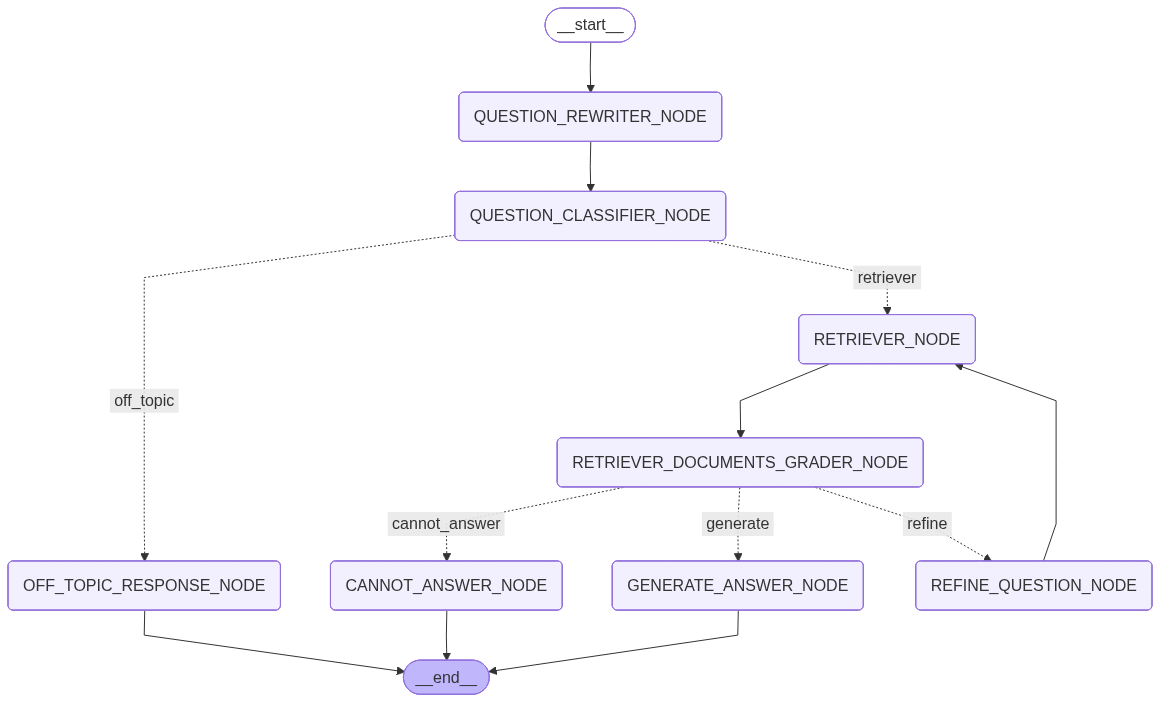

In [34]:
from IPython.display import display, Image


display(
    Image(workflow_graph.get_graph().draw_mermaid_png())
)

In [112]:
input_data = {"question": HumanMessage(content="What does the company Apple do?")}

workflow_graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Rewriter rephrased question:  content='What is the primary focus or range of products for the company Apple?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 51, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFj5CwYjkthoIDC3QIPsyHJzjTuPi', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--d58d9b42-766f-4724-a30f-912f994981e3-0' usage_metadata={'input_tokens': 51, 'output_tokens': 14, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Question Classifier on Topic: decision='No'


{'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
 'rephrashed_question': 'What is the primary focus or range of products for the company Apple?',
 'rephrashed_count': 0,
 'on_topic': 'No',
 'proceed_to_generate': False,
 'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question", additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry! I cannot answer this question", additional_kwargs={}, response_metadata={})],
 'document': []}

In [114]:

input_data = {
    "question": HumanMessage(
        content="What is the cancelation policy for Peak Performance Gym memberships?"
    )
}
workflow_graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Rewriter rephrased question:  content='What is the cancellation policy for Peak Performance Gym memberships?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 61, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFj64d0PmoOrrr2x0D5sWJSZCsPh4', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--ef080de6-7ae6-40e5-97b1-9175001b4e8c-0' usage_metadata={'input_tokens': 61, 'output_tokens': 11, 'total_tokens': 72, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Question Classifier on Topic: decision='Yes'
Retrieved documents: [Document(metadata={'source': 'hours.txt'}, page_content='Peak Pe

c:\Users\Admin\Desktop\langgraph\venv\Lib\site-packages\langchain_openai\chat_models\base.py:1909: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Grader Chain Decision: Yes
Retriever Grader, Question: What is the cancellation policy for Peak Performance Gym memberships? 

 Document: Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.
Grader Chain Decision: Yes
Retriever Grader, Question: What is the cancellation policy for Peak Performance Gym memberships? 

 Document: Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/sess

{'question': HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={}),
 'rephrashed_question': 'What is the cancellation policy for Peak Performance Gym memberships?',
 'rephrashed_count': 0,
 'on_topic': 'Yes',
 'proceed_to_generate': True,
 'messages': [HumanMessage(content='What is the cancelation policy for Peak Performance Gym memberships?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The cancelation policy for Peak Performance Gym memberships may vary depending on the specific terms and conditions of your membership agreement. It is recommended to refer to the membership contract or contact the gym directly for detailed information on their cancelation policy.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The cancellation policy for Peak Performance Gym memberships may vary depending on the specific terms and conditions of your membership agreement. It is re

In [110]:
input_data = {
    "question": HumanMessage(content="Who founded Peak Performance Gym?")
}
res = workflow_graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})
print(f"Final Message: {res["messages"][-1].content}")

Rewriter rephrased question:  content='Who is the founder of Peak Performance Gym?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 49, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFj4mljWYJh1JHPywu2JlYFT7cTXV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--e1d8c58c-fae5-4db7-889d-60bcb6516fe0-0' usage_metadata={'input_tokens': 49, 'output_tokens': 9, 'total_tokens': 58, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Question Classifier on Topic: decision='Yes'
Retrieved documents: [Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym was founded in

c:\Users\Admin\Desktop\langgraph\venv\Lib\site-packages\langchain_openai\chat_models\base.py:1909: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Grader Chain Decision: Yes
Retriever Grader, Question: Who is the founder of Peak Performance Gym? 

 Document: Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.
Grader Chain Decision: Yes
Retriever Grader, Question: Who is the founder of Peak Performance Gym? 

 Document: Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).
